# Approximation Methods

> “An approximate answer to the right problem is worth a good deal more than
an exact answer to an approximate problem.” -- John Tukey

Markov chain Monte Carlo (MCMC) is the *de facto* standard for the estimation of Bayesian models. It is an important and useful approach because it is asymptotically exact and can be implemented readily in software and applied to a wide range of probabilistic models. The main drawback of MCMC is its **computational expense**, as it requires repeated calculation of likelihoods and other quantities at every iteration of the algorithm. These calculations typically involve all of the data specified in the model, and hence do not scale well with the size of the dataset being used to fit the model.

An alternative to this employs one of several *approximation* methods. By an approximation, we are here referring to methods that do not exactly calculate or sample from the full posterior distribution specified by the model, but rather, either returns one or more moments of the posterior or use an alternative functional form in place of the true posterior distribution. We will outline two of these methods that are available in PyMC3.

## Maximum a posteriori (MAP) estimation

The most straightforward way for obtaining estimates from a Bayesian model is to find the maximum *a posteriori* estimate of the model parameters. This simply involves applying a numerical optimization algorithm to the model, several of which are available in the SciPy package for Python. Since the marginal likelihood is a constant with respect to the parameters, the estimates of the parameters derived from a non-normalized model will be the same as those from a normalized model. 

$$\hat{\theta}_{MAP}(y) = \text{argmax}_{\theta} \frac{Pr(y|\theta)Pr(\theta)}{\int Pr(y|\theta)Pr(\theta) d\theta} = \text{argmax}_{\theta} Pr(y|\theta)Pr(\theta) $$

Let's use MAP to obtain estimates for the survival model that we introduced previously.

In [7]:
# %load ../data/melanoma_data.py
from numpy import reshape, sum

melanoma_data = reshape([1.57808, 0.00000, 2, 1.27, 35.9945, 1, 1.48219,
     0.00000, 2, 0.76, 41.9014, 1, 0.0, 7.33425, 1, 35.00, 70.2164, 2, 2.23288,
     0.00000, 1, 1.70, 33.7096, 1, 0.0, 9.38356, 2, 1.00, 47.9726, 1, 3.27671,
     0.00000, 1, 11.00, 31.8219, 2, 0.0, 9.64384, 1, 6.50, 32.9479, 1, 1.66575,
     0.00000, 2, 3.62, 35.9205, 1, 0.94247, 0.00000, 1, 8.50, 40.5068, 2,
     1.68767, 0.00000, 2, 4.20, 57.0384, 1, 2.34247, 0.00000, 2, 5.00, 62.0630, 1,
     0.89863, 0.00000, 1, 2.25, 56.5342, 1, 0.0, 9.03288, 2, 2.30, 22.9945, 2,
     0.0, 9.63014, 2, 10.00, 18.4712, 1, 0.52603, 0.00000, 1, 3.35, 41.2521, 1,
     1.82192, 0.00000, 2, 3.80, 29.5178, 1, 0.93425, 0.00000, 1, 0.75, 59.0493, 2,
     0.0, 8.98630, 2, 0.50, 32.2877, 1, 3.35068, 0.00000, 1, 0.46, 26.4822, 1,
     8.67397, 0.00000, 1, 2.55, 55.0411, 1, 0.41096, 0.00000, 2, 1.95, 55.1233, 2,
     2.78630, 0.00000, 1, 2.50, 22.4055, 2, 2.56438, 0.00000, 1, 2.10, 50.8466, 1,
     0.0, 8.75342, 2, 9.00, 56.0274, 1, 0.56986, 0.00000, 2, 5.00, 55.4767, 1,
     0.0, 8.40000, 1, 0.55, 41.2411, 1, 0.0, 7.25205, 1, 12.50, 32.7425, 1,
     4.38630, 0.00000, 2, 1.16, 45.3479, 1, 0.0, 8.36712, 2, 4.25, 42.8438, 2,
     0.0, 8.99178, 2, 15.00, 51.1068, 1, 0.86575, 0.00000, 2, 0.72, 30.1808, 1,
     0.0, 4.76986, 1, 1.50, 58.7014, 2, 1.15616, 0.00000, 2, 6.50, 51.5397, 1,
     0.0, 7.28767, 1, 2.75, 27.1973, 1, 3.13151, 0.00000, 1, 3.83, 67.6740, 1,
     0.0, 8.55068, 2, 1.80, 64.4274, 2, 0.0, 8.45753, 2, 4.75, 35.4411, 1,
     4.59452, 0.00000, 1, 5.80, 35.9452, 1, 2.88219, 0.00000, 2, 0.51, 48.1370, 1,
     0.89589, 0.00000, 1, 3.25, 58.6082, 1, 1.76164, 0.00000, 2, 0.90, 40.0137, 2,
     0.0, 7.81370, 1, 3.45, 26.0055, 1, 0.0, 8.33425, 2, 1.38, 36.9616, 1,
     2.62192, 0.00000, 1, 5.28, 25.9068, 2, 0.16164, 0.00000, 2, 3.00, 63.8055, 1,
     0.0, 8.24658, 1, 2.20, 29.6986, 2, 1.52603, 0.00000, 1, 7.00, 61.6384, 1,
     5.30959, 0.00000, 1, 4.00, 49.9918, 1, 0.87123, 0.00000, 2, 2.36, 37.1068, 1,
     0.41644, 0.00000, 1, 1.06, 53.4658, 2, 4.24110, 0.00000, 1, 6.50, 57.7425, 2,
     0.13699, 0.00000, 1, 10.00, 29.1479, 1, 7.07671, 0.00000, 2, 1.20, 59.2466,
     1, 0.13151, 0.00000, 2, 15.00, 61.3507, 2, 0.0, 8.02740, 1, 0.49, 33.9205,
     2, 0.0, 6.16164, 2, 1.60, 43.1918, 1, 1.29863, 0.00000, 2, 11.50, 34.1890,
     2, 1.29041, 0.00000, 2, 1.90, 58.3808, 2, 0.0, 7.99726, 1, 4.80, 21.9479,
     2, 0.0, 8.34795, 1, 0.55, 35.1151, 1, 0.0, 7.30137, 2, 6.50, 31.6493, 1,
     2.32877, 0.00000, 2, 12.00, 56.1890, 1, 0.56438, 0.00000, 1, 7.00, 60.7123,
     1, 5.62740, 0.00000, 2, 6.50, 58.8329, 2, 1.23014, 0.00000, 1, 1.60,
     44.4849, 2, 0.0, 7.94521, 1, 1.15, 51.1315, 2, 5.06301, 0.00000, 1, 2.65,
     34.2164, 1, 3.27671, 0.00000, 2, 2.00, 35.2301, 1, 0.0, 0.60822, 2, 2.50,
     32.7425, 2, 0.65753, 0.00000, 1, 4.38, 38.0986, 2, 0.84110, 0.00000, 2,
     2.93, 45.7699, 1, 0.0, 8.40000, 2, 3.00, 44.2000, 1, 0.18356, 0.00000, 1,
     2.50, 71.3260, 1, 2.62466, 0.00000, 2, 2.30, 59.0795, 1, 0.0, 7.96438, 2,
     2.00, 35.3836, 2, 0.0, 7.77808, 1, 0.75, 58.0438, 2, 0.22192, 0.00000, 1,
     5.00, 43.2164, 1, 2.33973, 0.00000, 1, 10.00, 60.4932, 1, 0.52329, 0.00000,
     1, 0.87, 32.4795, 2, 0.0, 8.04110, 2, 1.33, 60.2986, 1, 0.0, 7.83288, 1,
     5.60, 47.1342, 1, 0.64110, 0.00000, 1, 2.55, 42.3233, 1, 0.38356, 0.00000,
     1, 6.50, 54.4164, 1, 0.0, 7.82192, 2, 1.20, 51.4219, 1, 0.51781, 0.00000,
     2, 3.00, 46.5973, 1, 0.0, 8.09863, 2, 2.55, 58.3562, 1, 0.0, 8.16712, 2,
     1.61, 25.6712, 2, 4.42740, 0.00000, 1, 1.40, 29.1726, 1, 0.88493, 0.00000,
     1, 2.25, 18.6795, 1, 2.78356, 0.00000, 1, 4.50, 60.9671, 2, 2.64658,
     0.00000, 2, 0.81, 63.8849, 2, 0.0, 8.21370, 2, 1.30, 37.9808, 2, 0.0,
     7.41918, 2, 3.20, 32.3507, 2, 0.99726, 0.00000, 1, 1.29, 42.9589, 1,
     5.88493, 0.00000, 2, 4.40, 40.9562, 1, 0.41644, 0.00000, 1, 6.00, 61.9753, 1,
     3.53699, 0.00000, 1, 3.93, 55.3315, 2, 0.0, 7.56164, 1, 0.60, 36.0767, 1,
     0.0, 7.53151, 1, 0.75, 50.6795, 1, 0.27671, 0.00000, 1, 0.73, 66.6986, 1,
     0.76986, 0.00000, 2, 0.20, 29.3479, 2, 0.0, 7.62192, 2, 3.88, 33.1863, 1,
     0.0, 7.79726, 1, 2.48, 48.6356, 2, 0.64110, 0.00000, 1, 2.50, 29.4877, 1,
     1.14521, 0.00000, 2, 10.00, 42.6685, 1, 2.01644, 0.00000, 1, 16.00, 24.4055,
     2, 2.84384, 0.00000, 1, 4.00, 40.3890, 1, 0.0, 7.00000, 2, 1.35, 45.4192,
     1, 1.27397, 0.00000, 2, 3.00, 65.3945, 1, 0.0, 7.09589, 1, 10.72, 47.5753,
     2, 2.04110, 0.00000, 1, 1.50, 58.4438, 2, 0.83562, 0.00000, 1, 3.50,
     59.2767, 2, 0.92329, 0.00000, 1, 1.10, 30.2630, 2, 0.07397, 0.00000, 1,
     1.00, 40.7370, 1, 0.0, 7.30685, 2, 5.10, 44.7452, 1, 2.07671, 0.00000, 2,
     0.50, 67.8329, 1, 0.0, 7.70959, 2, 4.03, 27.7452, 1, 0.0, 6.15890, 1,
     1.80, 25.9260, 2, 0.0, 6.89315, 2, 3.50, 31.2740, 1, 3.30685, 0.00000, 1,
     1.15, 58.8822, 2, 0.36164, 0.00000, 1, 1.75, 57.0575, 1, 1.97808, 0.00000,
     2, 2.50, 59.8137, 1, 1.23836, 0.00000, 2, 2.10, 77.5151, 1, 0.10685,
     0.00000, 1, 1.35, 43.4219, 1, 0.0, 7.63836, 1, 4.50, 52.2082, 1, 2.06301,
     0.00000, 1, 0.50, 36.3205, 2, 0.0, 7.42466, 2, 2.30, 25.9781, 1, 0.50959,
     0.00000, 1, 4.00, 49.4411, 1, 0.65753, 0.00000, 1, 5.40, 57.9589, 1, 0.0,
     6.93151, 1, 6.00, 65.5644, 1, 0.0, 7.23288, 2, 5.10, 72.3425, 1, 6.01096,
     0.00000, 1, 4.50, 68.8548, 1, 0.33699, 0.00000, 1, 1.45, 50.4438, 2, 0.0,
     6.47123, 2, 3.38, 48.2877, 1, 0.94795, 0.00000, 1, 3.00, 46.9479, 2,
     2.91781, 0.00000, 2, 1.20, 33.6000, 2, 1.59726, 0.00000, 2, 7.30, 51.1644, 2,
     0.84932, 0.00000, 2, 1.67, 47.7836, 1, 1.38356, 0.00000, 1, 4.00, 53.8795, 2,
     3.81644, 0.00000, 2, 2.10, 38.7068, 2, 0.0, 7.06849, 1, 10.00, 69.3205, 2,
     0.0, 7.04110, 2, 3.50, 66.0219, 1, 1.00274, 0.00000, 2, 1.10, 36.0329, 2,
     0.0, 6.34795, 2, 0.40, 63.4603, 1, 1.18082, 0.00000, 1, 0.70, 48.8986, 2,
     0.97534, 0.00000, 1, 5.00, 45.0575, 1, 2.16712, 0.00000, 1, 0.85, 57.6712, 2,
     0.0, 6.85479, 1, 4.80, 45.2000, 1, 1.38356, 0.00000, 1, 1.20, 49.0438, 1,
     1.71507, 0.00000, 2, 1.30, 51.4630, 1, 0.79452, 0.00000, 2, 5.80, 34.5479, 1,
     0.0, 6.86301, 2, 6.00, 47.6438, 2, 0.0, 6.50411, 1, 3.00, 38.7233, 2,
     0.42466, 0.00000, 2, 1.88, 54.0658, 1, 0.98630, 0.00000, 1, 2.60, 45.7397, 1,
     0.0, 6.13699, 2, 2.70, 47.2822, 2, 3.80000, 0.00000, 2, 6.00, 62.6411, 1,
     0.0, 6.48493, 1, 4.00, 62.0192, 2, 0.0, 6.96438, 2, 1.71, 41.0904, 2, 0.0,
     6.78082, 2, 1.60, 50.2712, 2, 0.56164, 0.00000, 2, 1.50, 49.5288, 2,
     2.67123, 0.00000, 1, 3.00, 70.8192, 1, 1.56712, 0.00000, 2, 0.90, 59.0712, 1,
     2.07397, 0.00000, 2, 4.00, 53.9041, 1, 0.33973, 0.00000, 1, 2.80, 44.7342, 1,
     3.37808, 0.00000, 2, 0.80, 22.1397, 1, 3.15068, 0.00000, 1, 0.70, 72.8575, 1,
     0.0, 6.81096, 2, 0.90, 61.4521, 1, 3.20822, 0.00000, 2, 12.00, 61.2904, 1,
     0.62740, 0.00000, 1, 5.78, 34.7507, 1, 1.64384, 0.00000, 1, 0.60, 67.4164, 2,
     1.40822, 0.00000, 1, 12.00, 53.2493, 1, 0.0, 6.06575, 1, 4.00, 49.0082, 1,
     1.66301, 0.00000, 2, 0.45, 56.7699, 1, 1.36986, 0.00000, 2, 1.30, 34.0247, 2,
     5.46849, 0.00000, 1, 0.81, 34.3014, 2, 0.42740, 0.00000, 1, 3.20, 45.0712, 2,
     1.13973, 0.00000, 2, 4.00, 54.7671, 2, 1.73699, 0.00000, 2, 4.77, 42.8548, 2,
     0.0, 5.54521, 2, 2.20, 36.6301, 2, 0.85205, 0.00000, 1, 3.00, 43.2466, 1,
     0.43014, 0.00000, 1, 3.00, 53.3562, 1, 1.20822, 0.00000, 2, 0.80, 35.3534, 1,
     4.36164, 0.00000, 1, 4.00, 36.5233, 1, 0.52877, 0.00000, 2, 5.00, 52.7863, 1,
     0.0, 6.51507, 1, 2.00, 24.4329, 2, 2.89863, 0.00000, 2, 3.85, 58.7178, 1,
     0.0, 6.20274, 2, 0.76, 45.5479, 1, 1.21644, 0.00000, 2, 0.75, 43.3014, 2,
     0.0, 6.00000, 2, 6.50, 51.4055, 2, 0.0, 6.25479, 1, 0.85, 38.9671, 2, 0.0,
     6.49863, 1, 4.30, 68.2658, 1, 1.13699, 0.00000, 2, 2.10, 59.4493, 2,
     1.69589, 0.00000, 1, 1.50, 30.0192, 1, 0.0, 6.41096, 2, 2.00, 22.1562, 2,
     0.0, 6.02192, 1, 11.00, 54.7671, 1, 3.04932, 0.00000, 2, 4.88, 45.0384, 1,
     0.0, 5.62740, 2, 5.20, 39.7589, 1, 0.72603, 0.00000, 1, 3.04, 41.3808, 1,
     0.73425, 0.00000, 2, 8.00, 34.9671, 1, 1.47945, 0.00000, 2, 1.60, 46.3479, 1,
     0.37808, 0.00000, 2, 1.10, 29.9233, 2, 0.0, 5.75890, 2, 3.00, 32.8740, 1,
     1.48219, 0.00000, 2, 10.00, 39.5397, 2, 0.0, 5.88493, 1, 1.95, 55.4822, 1,
     0.0, 1.80274, 1, 2.00, 32.3562, 1, 1.40548, 0.00000, 2, 3.70, 41.8027, 2,
     0.0, 4.74795, 1, 2.90, 35.3452, 2, 0.0, 5.24658, 1, 1.80, 50.4795, 1,
     0.29041, 0.00000, 1, 6.00, 61.3507, 2, 0.0, 5.83836, 1, 1.50, 67.3562, 1,
     0.0, 5.32055, 2, 1.75, 53.8548, 2, 5.16712, 0.00000, 2, 5.00, 78.7315, 2,
     0.0, 5.59178, 2, 0.63, 62.7233, 1, 0.0, 5.77808, 1, 1.15, 65.1507, 1,
     0.53425, 0.00000, 2, 1.50, 34.8274, 1, 0.0, 2.22466, 1, 0.98, 33.8466, 2,
     3.59726, 0.00000, 1, 5.00, 67.8822, 1, 0.0, 5.32329, 1, 5.50, 66.0712, 2,
     1.78630, 0.00000, 2, 1.00, 55.0658, 2, 0.70411, 0.00000, 2, 10.00, 50.5123,
     1, 0.0, 4.94795, 2, 5.00, 42.4055, 2, 0.0, 5.45479, 2, 3.75, 58.1068, 2,
     4.32877, 0.00000, 1, 10.00, 26.0137, 1, 1.16164, 0.00000, 2, 3.00, 54.4685,
     1, 0.0, 5.20274, 2, 8.00, 54.0630, 2, 0.0, 4.40822, 1, 1.64, 34.5589, 1,
     1.41096, 0.00000, 1, 4.95, 58.5068, 1, 0.0, 4.92877, 2, 1.45, 63.9370, 1,
     0.0, 5.42192, 2, 12.00, 49.8274, 2, 0.98904, 0.00000, 1, 2.05, 50.5562, 1,
     0.36438, 0.00000, 1, 3.60, 40.4795, 2, 0.0, 4.38082, 1, 8.30, 61.7479, 2,
     0.77260, 0.00000, 2, 0.45, 41.6712, 1, 4.90959, 0.00000, 2, 3.00, 25.5096, 1,
     1.26849, 0.00000, 1, 4.40, 61.2000, 1, 0.58082, 0.00000, 2, 1.10, 53.1260, 1,
     0.0, 4.95616, 1, 1.05, 40.4658, 1, 0.0, 5.12329, 1, 1.71, 60.3068, 1, 0.0,
     4.74795, 1, 6.30, 48.7425, 2, 0.0, 4.90685, 2, 0.50, 46.7562, 2, 1.41918,
     0.00000, 1, 5.10, 34.8932, 2, 0.44110, 0.00000, 1, 6.00, 33.3096, 1, 0.0,
     4.29863, 2, 1.50, 35.7589, 1, 0.0, 4.63836, 2, 0.36, 49.8575, 1, 0.0,
     4.81370, 1, 3.00, 57.3726, 2, 4.50137, 0.00000, 2, 1.24, 29.7726, 2,
     3.92329, 0.00000, 2, 0.70, 51.8822, 2, 0.0, 4.86027, 2, 0.80, 65.3123, 2,
     0.52603, 0.00000, 1, 1.00, 52.0658, 2, 2.10685, 0.00000, 2, 3.38, 60.9534, 2,
     0.0, 4.24384, 1, 1.52, 32.6055, 2, 3.39178, 0.00000, 1, 2.20, 51.5123, 2,
     0.0, 4.36164, 2, 2.10, 48.6548, 1, 0.0, 4.81918, 2, 1.40, 43.8438, 2],
(255, 6))

# Censoring indicator
censored = (melanoma_data[:, 0] == 0).astype(int)
# Time
t = sum(melanoma_data[:, 0:2], 1)
# Treatment
treat = melanoma_data[:, 2].astype(int) - 1
# Breslow scale
breslow = melanoma_data[:, 3]
# Age and sex
age = melanoma_data[:, 4]
sex = melanoma_data[:, 5].astype(int) - 1


In [8]:
from pymc3 import Normal, Model, DensityDist, sample, log, exp

with Model() as melanoma_survival:

    # Convert censoring indicators to indicators for failure event
    failure = (censored==0).astype(int)

    # Parameters (intercept and treatment effect) for survival rate
    beta = Normal('beta', mu=0.0, sd=1e5, shape=2)

    # Survival rates, as a function of treatment
    lam = exp(beta[0] + beta[1]*treat)
    
    # Survival likelihood, accounting for censoring
    def logp(failure, value):
        return (failure * log(lam) - lam * value).sum()

    x = DensityDist('x', logp, observed={'failure':failure, 'value':t})



The MAP estimate can be obtained in PyMC3 via the `find_MAP` function. As with `sample`, we run `find_MAP` inside a model context, or pass the model explicitly to the function as the `model` parameter.

Starting values can be optionally passed as a `dict` to the `start` parameter. By default, `fmin_MAP` uses SciPy's `fmin_bfgs` function to find the maximum, which is an implementation of the [Broyden–Fletcher–Goldfarb–Shanno algorithm](https://en.wikipedia.org/wiki/Broyden–Fletcher–Goldfarb–Shanno_algorithm). If there are discrete variables in the model, then `fmin_powell` is used, which is SciPy's implementation of [Powell's method](https://en.wikipedia.org/wiki/Powell%27s_method), a more general algorithm.

In [9]:
from pymc3 import find_MAP

with melanoma_survival:
    estimates = find_MAP()

For this model, the MAP estimates are comparable to those we would have obtained using MCMC sampling:

In [10]:
from pymc3 import sample

with melanoma_survival:
    trace = sample(1000)

Assigned NUTS to beta
 [-----------------100%-----------------] 1000 of 1000 complete in 0.5 sec

In [11]:
from pymc3 import summary

summary(trace)


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -1.675           0.158            0.010            [-1.937, -1.479]
  -0.271           0.173            0.008            [-0.575, 0.063]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.917         -1.762         -1.674         -1.598         -1.452
  -0.579         -0.399         -0.277         -0.148         0.063



`find_MAP` only returns estimates unobserved random variables from the model, and does not include deterministic values. If we wish to evaluate a determinsitic quantity, we can construct a Theano function and pass in the relevant parameter values as arguments.

### Exercise: calculating deterministic quantities

Create a Theano function to evaluate the deterministic `lam` variable at the MAP estimates for beta:

In [12]:
from theano import function

# Write your answer here

The major limitation to using MAP for inference is that there is no associated measure of uncertainty. Hence, `find_MAP` cannot be used for inference. It is useful, however, for getting a sense of typical values the model may take for a particular dataset, and for PyMC3 it is intended to be used to get reasonable starting values for use in MCMC algorithms.

## Variational Inference

An alternative approach to approximating the posterior disstribution that is difficult to calculate analytically is to perform inference on an appoximation to the true posterior distribution. 

The idea is to choose a convenient approximating density $q(\theta, \phi)$, with vector of corresponding parameters $\phi$. The goal is to select $\phi$ such that $q(\theta, \phi)$ is as similar as possible to the true posterior. We therefore require a loss function that measures the similarity of $q(\theta, \phi)$ to $p(\theta| y)$.

The loss function employed by variational inference is the **Kullback-Leibler distance**:

$$\text{KL}[q(\theta, \phi) || p(\theta| y)] = \int q(\theta, \phi) \frac{q(\theta, \phi)}{p(\theta| y)} d\theta$$

However, this integral is difficult to work with, so instead a proxy to KL, called the evidence lower bound, is minimized instead:

$$ELBO = \mathbb{E}_{q(\theta)} [\log p(y, \theta)] − \mathbb{E}_{q(θ)} [\log q(\theta, \phi)]$$

The first term of the ELBO expression $\mathbb{E}_{q(\theta)} [\log p(y, \theta)]$ is the expectation of the log joint density under the approximation, while the second term $\mathbb{E}_{q(θ)} [\log q(\theta, \phi)]$ is called the *entropy* of the variational approximation.

Algorithms for performing variational inference are difficult to construct, and this has limited its adoption for applications.

### Automatic Differentiation Variational Inference

Kucukelbir et al. (2015) devised a method for automating the variational inference approach, by making a flexible choice for the approximating distribution, and transforming the latent variables to an unconstrained coordinate space before fitting the model.

ADVI proceeds in three steps:

1. Transform the model's latent variables to the real coordinate space
2. Specify a normal variational distribution.
3. Maximize the variational objective via automatic differentiation and stochastic optimization

The ADVI procedure works for differentiable probability models (*i.e.* those comprised of continuous latent variables) only. This is because it requires the calculation of the gradient of the log-joint with respect to the stochastic variables:

$$\nabla_{\theta} \log p(y, \theta)$$

The key to making ADVI work is the transformation of constrained parameters to the unconstrained, real coordinate space. This allows us to use a Gaussian distribution as the variational density. As with the classical variational inference algorithm, we impose the mean field assumption, whereby the Gaussian distributions over all the parameters can be fully factorized:

$$q(\zeta, \phi) = \prod_{j=1}^J N(\zeta | \mu_j, \sigma_j^2)$$

where $\zeta$ are the parameters after tranformation by $T: \theta \rightarrow \zeta$.

The inverse of the transform used (*e.g.* log for positive variables, logit for probabilities) and the associated Jacobian allows for a non-normal variational approximation on the support of the original variable.

In [14]:
import numpy as np

data = np.random.randn(100)

In [15]:
import pymc3 as pm

with pm.Model() as model: 
    mu = pm.Normal('mu', mu=0, sd=1, testval=0)
    sd = pm.HalfNormal('sd', sd=1)
    n = pm.Normal('n', mu=mu, sd=sd, observed=data)

Applied log-transform to sd and added transformed sd_log to model.


In [16]:
with model:
    
    means, sds, elbos = pm.variational.advi(model=model, n=10000, accurate_elbo=True)

Iteration 0 [0%]: ELBO = -843.14
Iteration 1000 [10%]: Average ELBO = -658.32
Iteration 2000 [20%]: Average ELBO = -243.64
Iteration 3000 [30%]: Average ELBO = -181.58
Iteration 4000 [40%]: Average ELBO = -165.68
Iteration 5000 [50%]: Average ELBO = -157.39
Iteration 6000 [60%]: Average ELBO = -153.11
Iteration 7000 [70%]: Average ELBO = -151.13
Iteration 8000 [80%]: Average ELBO = -150.31
Iteration 9000 [90%]: Average ELBO = -150.09
Finished [100%]: Average ELBO = -150.06


In [17]:
means

{'mu': array(0.09900916031993148), 'sd_log': array(0.043599325193635664)}

In [18]:
with model:
    trace = pm.sample(1000)

Assigned NUTS to mu
Assigned NUTS to sd_log
 [-----------------100%-----------------] 1000 of 1000 complete in 1.3 sec

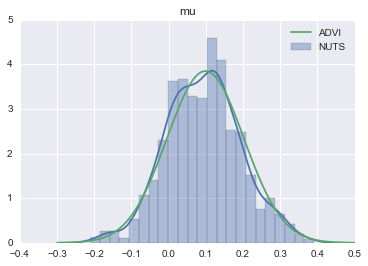

In [22]:
%matplotlib inline
import seaborn as sns
from scipy import stats

ax = sns.distplot(trace['mu'], label='NUTS')
xlim = ax.get_xlim()
x = np.linspace(xlim[0], xlim[1], 100)
y = stats.norm(means['mu'], sds['mu']).pdf(x)
ax.plot(x, y, label='ADVI')
ax.set_title('mu')
ax.legend(loc=0)

## References

1.	Kucukelbir A, Ranganath R, Gelman A, Blei DM. Automatic Variational Inference in Stan. arXiv. 2015;stat.ML.